# <h1 align=center>Emotion Recognition</h1>

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from livelossplot import PlotLossesKerasTF
import tensorflow as tf
import time

In [13]:
print("\nTraining dataset\n")
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")
print("\nTest dataset\n")
for expression in os.listdir("test/"):
    print(str(len(os.listdir("test/" + expression))) + " " + expression + " images")


Training dataset

1 angry images
1 disgust images
1 fear images
1 happy images
1 neutral images
1 sad images
1 surprise images

Test dataset

1 test images


In [14]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='sparse',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=False)
validation_generator = datagen_validation.flow_from_directory("test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='sparse',
                                                    shuffle=False)

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 1 classes.


In [15]:
# Verificar las primeras etiquetas generadas por el generador
print(train_generator.class_indices)
batch = next(train_generator)
print(batch[1])  

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
[6. 6. 3. 5. 0. 4. 6. 0. 2. 5. 4. 3. 1. 6. 6. 3. 2. 2. 1. 3. 0. 4. 5. 4.
 4. 5. 5. 0. 4. 4. 3. 2. 5. 4. 0. 3. 2. 2. 3. 4. 0. 3. 4. 3. 0. 3. 0. 3.
 5. 5. 6. 3. 0. 0. 3. 5. 0. 3. 0. 3. 3. 6. 2. 5.]


In [16]:
x_batch, y_batch = next(train_generator)
print(f"x_batch shape: {x_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")

x_batch shape: (64, 48, 48, 1)
y_batch shape: (64,)


In [17]:
# Definir el modelo
model = Sequential()

# Primera capa de convolución
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Segunda capa de convolución
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Tercera capa de convolución
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Cuarta capa de convolución
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Aplanado y capas densas
model.add(Flatten())

# Primera capa densa
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Segunda capa densa
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Capa de salida
model.add(Dense(7, activation='softmax'))

# Compilación del modelo
opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,02

 Total params: 3,002,887 (11.46 MB)

 Trainable params: 2,999,431 (11.44 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [18]:
# condiciones de parada temprana
earlystop_acc = EarlyStopping(monitor="val_accuracy",
                                  min_delta=0.001,
                                  patience=10,
                                  mode="max",
                                  restore_best_weights=True)

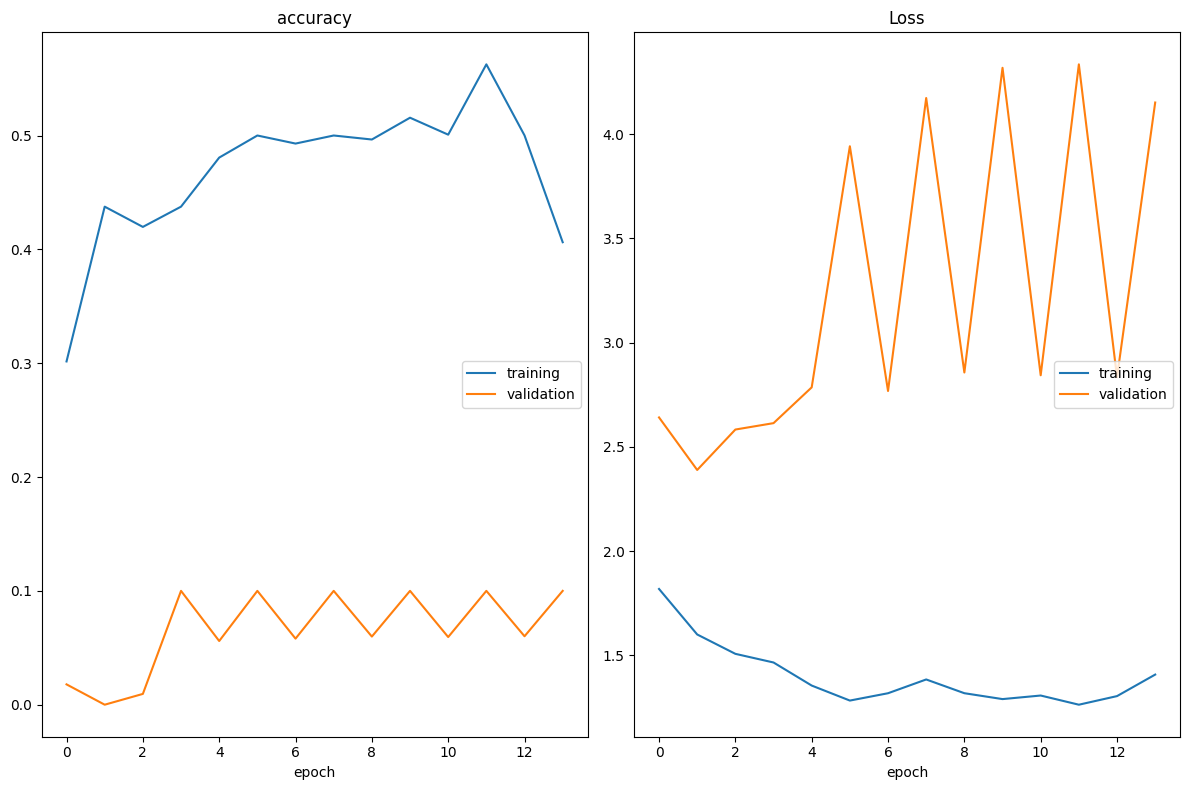

accuracy
	training         	 (min:    0.302, max:    0.562, cur:    0.406)
	validation       	 (min:    0.000, max:    0.100, cur:    0.100)
Loss
	training         	 (min:    1.263, max:    1.818, cur:    1.407)
	validation       	 (min:    2.389, max:    4.336, cur:    4.152)

Epoch 14: val_accuracy did not improve from 0.10000
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4062 - loss: 1.4074 - val_accuracy: 0.1000 - val_loss: 4.1524 - learning_rate: 1.0000e-05
Tiempo total de entrenamiento: 3661.713359594345 segundos


In [19]:
# Configuración de entrenamiento
epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=2, min_lr=1e-5, mode='auto', verbose=1
)
checkpoint = ModelCheckpoint(
    "best_model.keras", monitor='val_accuracy', save_weights_only=False,
    mode='max', verbose=1, save_best_only=True
)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr, earlystop_acc]

# Medición del tiempo de entrenamiento
start_time = time.time()

# Entrenamiento del modelo
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# Mostrar tiempo de entrenamiento
end_time = time.time()
print("Tiempo total de entrenamiento:", end_time - start_time, "segundos")